<a href="https://colab.research.google.com/github/carlosfer1982/IAAPL2024_2025/blob/main/benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fase 1 - Benchmarking - Previsão com o Modelo pré-treinado

* Precisão top-1 e top-5 por classe
* Gráfico comparativo entre classes
* Benchmarking rigoroso com o modelo pré-treinado

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔍 Avaliando imagens com VGG16 pré-treinado...


Classe: elephant: 100%|██████████| 11/11 [00:09<00:00,  1.22it/s]



✅ Resultados gerais:
Total de imagens avaliadas: 98
Top-5 acertos: 62 (63.27%)
Top-1 acertos: 48 (48.98%)

📊 Resultados por classe:
bear:
  Total: 14
  Top-1: 13 (92.86%)
cat:
  Total: 13
  Top-1: 7 (53.85%)
dog:
  Total: 12
  Top-1: 5 (41.67%)
goat:
  Total: 15
  Top-1: 0 (0.00%)
horse:
  Total: 15
  Top-1: 0 (0.00%)
lion:
  Total: 6
  Top-1: 6 (100.00%)
tiger:
  Total: 6
  Top-1: 6 (100.00%)
wolf:
  Total: 6
  Top-1: 2 (33.33%)
elephant:
  Total: 11
  Top-1: 9 (81.82%)

🔍 Reavaliando imagens para matriz de confusão...


<Figure size 1000x800 with 0 Axes>

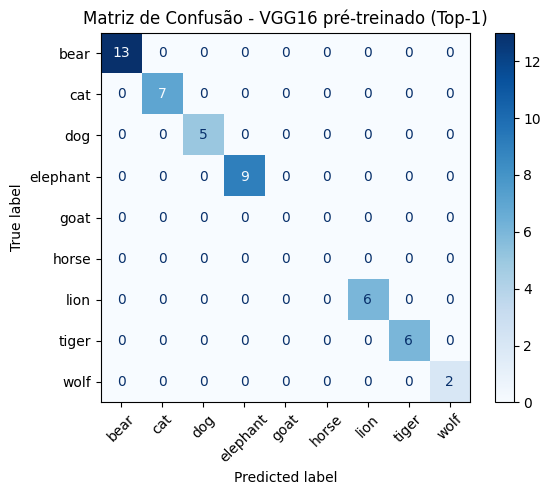

In [ ]:
# ===============================================
# Classificação de Animais com 3 Abordagens VGG16
# Autor: [Seu Nome]
# IA Aplicada - Comparação de modelos
# ===============================================

from google.colab import drive
drive.mount('/content/drive')
import os

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

# Caminho da base de validação
VAL_PATH = "/content/drive/MyDrive/ISEP/dataset/validation"

# Mapeamento das suas classes para possíveis rótulos da ImageNet
mapa_imagenet = {
    "dog": ["Labrador_retriever", "golden_retriever", "beagle", "pug", "Chihuahua",
            "malamute", "papillon", "Pekinese", "German_shepherd", "Bernese_mountain_dog"],
    "cat": ["tabby", "Persian_cat", "Siamese_cat", "Egyptian_cat"],
    "horse": ["Arabian_horse", "horse_cart"],
    "lion": ["lion"],
    "tiger": ["tiger"],
    "goat": ["goat", "mountain_goat"],
    "elephant": ["African_elephant", "Indian_elephant"],
    "bear": ["brown_bear", "American_black_bear", "ice_bear"],
    "wolf": ["timber_wolf", "Arctic_wolf", "white_wolf"]
}

# Carrega o modelo VGG16 pré-treinado
model = VGG16(weights='imagenet')

# salva modelo no google drive
model.save("/content/drive/MyDrive/ISEP/modelo_vgg16_pretreinado.keras")

# Contadores globais
total_global = 0
top1_global = 0
top5_global = 0

# Contadores por classe
resultados_por_classe = defaultdict(lambda: {"total": 0, "top1": 0, "top5": 0})

print("🔍 Avaliando imagens com VGG16 pré-treinado...")

# Itera pelas classes
for classe in os.listdir(VAL_PATH):
    classe_path = os.path.join(VAL_PATH, classe)
    if not os.path.isdir(classe_path):
        continue

    subclass_labels = mapa_imagenet.get(classe, [])

    for nome_img in tqdm(os.listdir(classe_path), desc=f"Classe: {classe}"):
        img_path = os.path.join(classe_path, nome_img)

        try:
            img = image.load_img(img_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            preds = model.predict(x, verbose=0)
            decoded = decode_predictions(preds, top=5)[0]

            total_global += 1
            resultados_por_classe[classe]["total"] += 1

            top_labels = [label for (_, label, _) in decoded]
            if any(lbl in subclass_labels for lbl in top_labels):
                top5_global += 1
                resultados_por_classe[classe]["top5"] += 1
            if decoded[0][1] in subclass_labels:
                top1_global += 1
                resultados_por_classe[classe]["top1"] += 1

        except Exception as e:
            print(f"Erro na imagem {img_path}: {e}")
            continue

# Resultados globais
print("\n✅ Resultados gerais:")
print(f"Total de imagens avaliadas: {total_global}")
print(f"Top-5 acertos: {top5_global} ({top5_global/total_global*100:.2f}%)")
print(f"Top-1 acertos: {top1_global} ({top1_global/total_global*100:.2f}%)")



# Resultados por classe
print("\n📊 Resultados por classe:")
true_labels = []
pred_labels = []

for classe, res in resultados_por_classe.items():
    total = res["total"]
    top1 = res["top1"]
    print(f"{classe}:")
    print(f"  Total: {total}")
    print(f"  Top-1: {top1} ({top1/total*100:.2f}%)")

# Geração da matriz de confusão com rótulos verdadeiros e previstos
print("\n🔍 Reavaliando imagens para matriz de confusão...")

true_labels.clear()
pred_labels.clear()

for classe in os.listdir(VAL_PATH):
    classe_path = os.path.join(VAL_PATH, classe)
    if not os.path.isdir(classe_path):
        continue

    subclass_labels = mapa_imagenet.get(classe, [])
    for nome_img in os.listdir(classe_path):
        img_path = os.path.join(classe_path, nome_img)

        try:
            img = image.load_img(img_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            preds = model.predict(x, verbose=0)
            decoded = decode_predictions(preds, top=1)[0][0]

            # Ground truth e predição
            true_labels.append(classe)

            # Verifica se a predição é uma das subclasses conhecidas
            pred_class = None
            for key, labels in mapa_imagenet.items():
                if decoded[1] in labels:
                    pred_class = key
                    break
            if pred_class is None:
                pred_class = "desconhecido"

            pred_labels.append(pred_class)

        except Exception as e:
            continue

# Classes esperadas
classes_ordenadas = sorted(mapa_imagenet.keys())

# Gera matriz de confusão
cm = confusion_matrix(true_labels, pred_labels, labels=classes_ordenadas)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_ordenadas)

# Exibe gráfico
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title("Matriz de Confusão - VGG16 pré-treinado (Top-1)")
plt.show()


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import os

classes_debug = ["horse", "goat"]
n_predicoes = 5  # Número de predições que queremos ver

for classe in classes_debug:
    classe_path = os.path.join(VAL_PATH, classe)
    if not os.path.isdir(classe_path):
        print(f"⚠️ Pasta não encontrada para: {classe}")
        continue

    print(f"\n🔍 Classe: {classe}")
    imagens = os.listdir(classe_path)

    if not imagens:
        print("⚠️ Nenhuma imagem encontrada nesta classe.")
        continue

    for nome_img in imagens:
        img_path = os.path.join(classe_path, nome_img)
        try:
            img = image.load_img(img_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            preds = model.predict(x, verbose=0)
            decoded_preds = decode_predictions(preds, top=n_predicoes)[0]

            print(f"\n📁 Imagem: {nome_img}")
            for rank, (id_, label, score) in enumerate(decoded_preds):
                print(f"  Top-{rank+1}: {label} ({score*100:.2f}%)")

        except Exception as e:
            print(f"Erro ao processar {nome_img}: {e}")

    # Limita a saída a apenas algumas imagens (opcional)
    print(f"\n✅ Fim da análise da classe {classe}. Total de imagens analisadas: {len(imagens)}\n")



🔍 Classe: horse

📁 Imagem: 01_016.png
  Top-1: Rhodesian_ridgeback (35.03%)
  Top-2: hartebeest (21.60%)
  Top-3: boxer (9.31%)
  Top-4: vizsla (8.28%)
  Top-5: sorrel (5.06%)

📁 Imagem: 01_015.png
  Top-1: hartebeest (47.55%)
  Top-2: whippet (3.61%)
  Top-3: African_hunting_dog (3.08%)
  Top-4: impala (3.02%)
  Top-5: gazelle (2.47%)

📁 Imagem: 01_048.png
  Top-1: sorrel (94.30%)
  Top-2: hartebeest (2.10%)
  Top-3: worm_fence (0.81%)
  Top-4: Arabian_camel (0.53%)
  Top-5: gazelle (0.48%)

📁 Imagem: 01_014.png
  Top-1: sorrel (98.53%)
  Top-2: Rhodesian_ridgeback (0.68%)
  Top-3: hartebeest (0.30%)
  Top-4: Ibizan_hound (0.22%)
  Top-5: ox (0.05%)

📁 Imagem: 01_018.png
  Top-1: sorrel (92.05%)
  Top-2: Rhodesian_ridgeback (2.10%)
  Top-3: boxer (1.97%)
  Top-4: Ibizan_hound (1.40%)
  Top-5: basenji (1.11%)

📁 Imagem: 02_103.png
  Top-1: dalmatian (70.37%)
  Top-2: hyena (10.75%)
  Top-3: African_hunting_dog (6.50%)
  Top-4: llama (4.21%)
  Top-5: English_setter (3.84%)

📁 Imagem: 0

# Fase 2 - Transfer Learning com VGG16

* Carregar a VGG16 pré-treinada, sem as camadas densas finais (include_top=False).
* Congelar a base convolucional e adicionar novas camadas densas para classificar as tuas 9 classes.
* Aplicar data augmentation durante o treinamento.
* Treinar com early stopping.
* Avaliar desempenho com matriz de confusão.

O que entrega?
* Gráficos com a evolução da acurácia durante o treino.
* Matriz de confusão com os erros mais comuns.
* Relatório detalhado por classe com precision, recall e F1-score.
* Modelo salvo no seu Google Drive.

Found 610 images belonging to 9 classes.
Found 96 images belonging to 9 classes.
📚 Classes: ['bear', 'cat', 'dog', 'elephant', 'goat', 'horse', 'lion', 'tiger', 'wolf']
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 430s 21s/step - accuracy: 0.1368 - loss: 3.9362 - val_accuracy: 0.3958 - val_loss: 1.6805
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 434s 22s/step - accuracy: 0.4940 - loss: 1.5248 - val_accuracy: 0.5208 - val_loss: 1.1664
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 404s 21s/step - accuracy: 0.6667 - loss: 1.0424 - val_accuracy: 0.6042 - val_loss: 1.0169
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 415s 21s/step - accuracy: 0.7087 - loss: 0.8099 - val_accuracy: 0.7292 - val_loss: 0.7608
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 436s 21s/step - accuracy: 0.7971 - loss: 0.6731 - val_accuracy: 0.6458 - val_loss: 0.9415
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 403s 20s/step - accuracy: 0.7985 - loss: 0.5966 - val_accuracy: 0.6771 - val_loss: 0.9482
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 439s 22s/step - accuracy: 0.7783 - loss: 0.6202 - val_accuracy: 0.6771 - val_loss: 0.8862
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 487s 24s/step - accuracy: 0.8300 - loss: 0.5673 - val_accuracy: 0.7

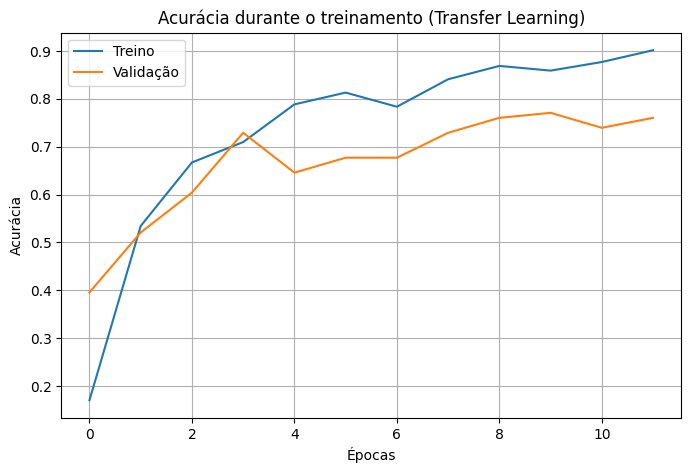

3/3 ━━━━━━━━━━━━━━━━━━━━ 66s 18s/step


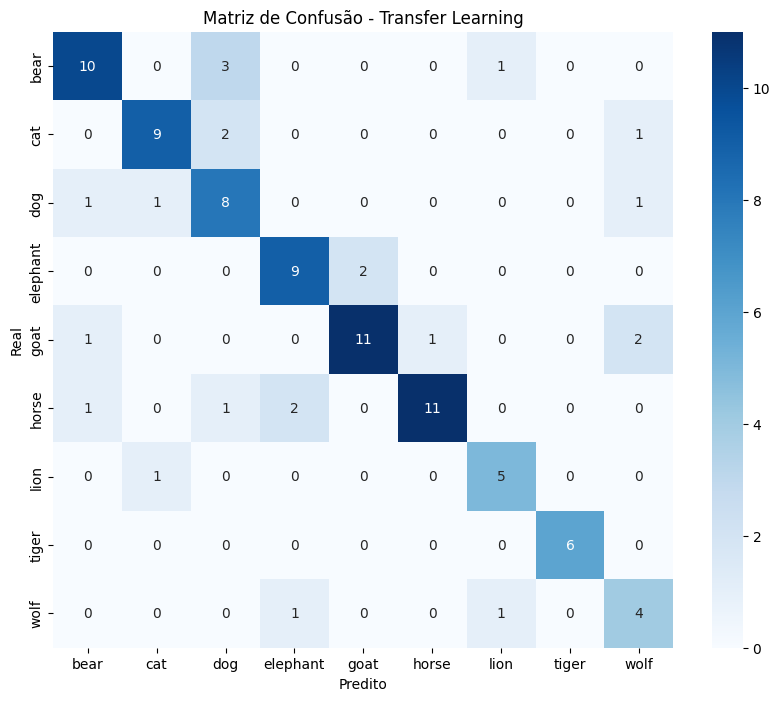


📊 Relatório de Classificação:

              precision    recall  f1-score   support

        bear       0.77      0.71      0.74        14
         cat       0.82      0.75      0.78        12
         dog       0.57      0.73      0.64        11
    elephant       0.75      0.82      0.78        11
        goat       0.85      0.73      0.79        15
       horse       0.92      0.73      0.81        15
        lion       0.71      0.83      0.77         6
       tiger       1.00      1.00      1.00         6
        wolf       0.50      0.67      0.57         6

    accuracy                           0.76        96
   macro avg       0.77      0.78      0.77        96
weighted avg       0.78      0.76      0.77        96



In [ ]:
# Fase 2 - Transfer Learning com VGG16
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Caminho do dataset
DATASET_PATH = "/content/drive/MyDrive/ISEP/dataset"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "validation")

# Dimensões padrão para VGG16
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 9
EPOCHS = 20

# Data augmentation no treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print("📚 Classes:", class_names)

# Carregar modelo base VGG16 sem as camadas finais
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar base

# Adicionar novas camadas densas
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compilar
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treinar com early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=[early_stop])

# Fine-tuning: descongelar últimas camadas da VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compilar com taxa de aprendizado menor
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

# Treinar mais 5 épocas com fine-tuning
history_finetune = model.fit(train_generator, validation_data=val_generator, epochs=5, callbacks=[early_stop])

# Salvar o modelo
model.save("/content/drive/MyDrive/ISEP/modelo_transfer_learning.keras")

# Plotar histórico de treino
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"] + history_finetune.history["accuracy"], label="Treino")
plt.plot(history.history["val_accuracy"] + history_finetune.history["val_accuracy"], label="Validação")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.title("Acurácia durante o treinamento (Transfer Learning)")
plt.grid(True)
plt.show()

# Avaliação final com matriz de confusão
# Prever rótulos da base de validação
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusão - Transfer Learning")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# Relatório por classe (precision, recall, f1-score)
print("\n📊 Relatório de Classificação:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


# Fase 3 - Treinamento do Zero

* Treinamento completo do VGG16 com pesos aleatórios.
* Data augmentation incluído.
* Early stopping automático.
* Gráfico da evolução da acurácia.
* Matriz de confusão.
* Relatório com métricas por classe.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 TensorFlow: 2.18.0
💻 Acelerador disponível: []
/bin/bash: line 1: nvidia-smi: command not found
               total        used        free      shared  buff/cache   available
Mem:            12Gi       2.5Gi       7.4Gi       1.0Mi       2.8Gi       9.9Gi
Swap:             0B          0B          0B
Found 610 images belonging to 9 classes.
Found 96 images belonging to 9 classes.
📚 Classes: ['bear', 'cat', 'dog', 'elephant', 'goat', 'horse', 'lion', 'tiger', 'wolf']


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1214s 60s/step - accuracy: 0.1270 - loss: 2.3947 - val_accuracy: 0.1250 - val_loss: 2.1956
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1221s 63s/step - accuracy: 0.1218 - loss: 2.2013 - val_accuracy: 0.1146 - val_loss: 2.1953
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1205s 60s/step - accuracy: 0.1421 - loss: 2.1961 - val_accuracy: 0.1146 - val_loss: 2.1930
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1227s 60s/step - accuracy: 0.1326 - loss: 2.1936 - val_accuracy: 0.1146 - val_loss: 2.1965
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1200s 60s/step - accuracy: 0.1425 - loss: 2.1956 - val_accuracy: 0.1146 - val_loss: 2.2021
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1200s 60s/step - accuracy: 0.1296 - loss: 2.1942 - val_accuracy: 0.1146 - val_loss: 2.1935
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1232s 62s/step - accuracy: 0.1233 - loss: 2.1964 - val_accuracy: 0.1146 - val_loss: 2.1925
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 1215s 61s/step - accuracy: 0.1233 - loss: 2.1952 - val_accu

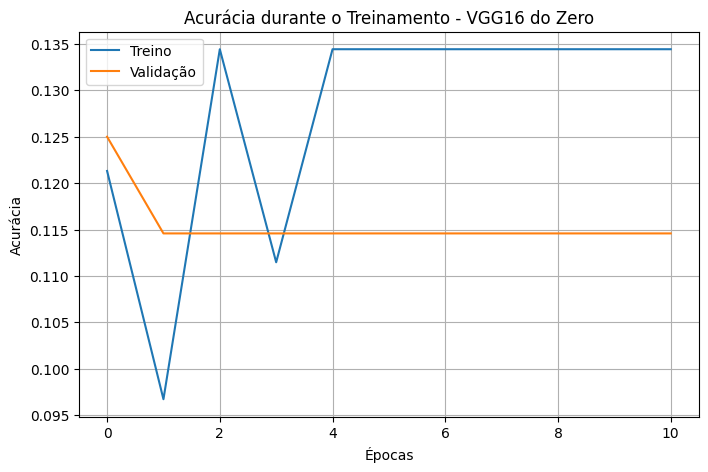

3/3 ━━━━━━━━━━━━━━━━━━━━ 56s 18s/step


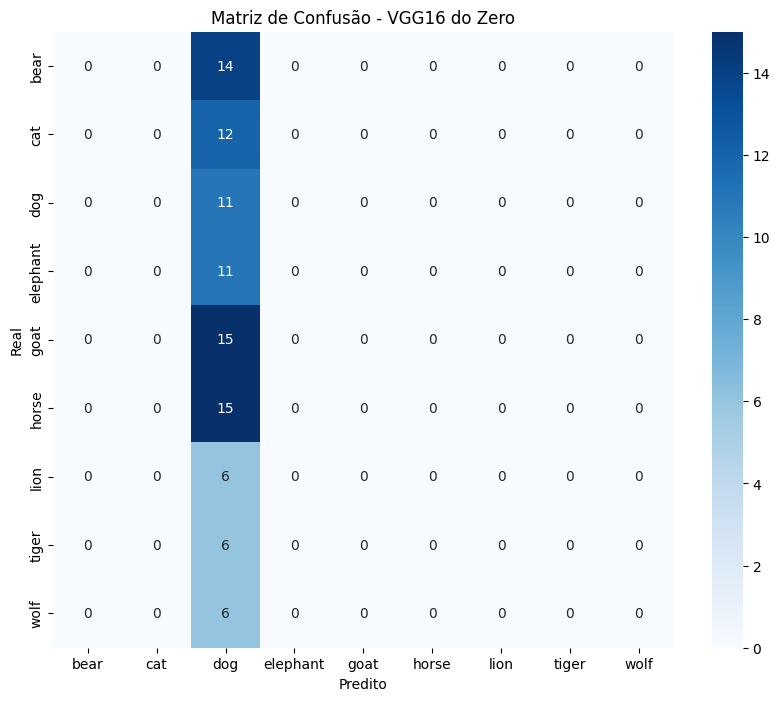


📊 Relatório de Classificação:

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        14
         cat       0.00      0.00      0.00        12
         dog       0.11      1.00      0.21        11
    elephant       0.00      0.00      0.00        11
        goat       0.00      0.00      0.00        15
       horse       0.00      0.00      0.00        15
        lion       0.00      0.00      0.00         6
       tiger       0.00      0.00      0.00         6
        wolf       0.00      0.00      0.00         6

    accuracy                           0.11        96
   macro avg       0.01      0.11      0.02        96
weighted avg       0.01      0.11      0.02        96


⏱️ Tempo total de execução: 13491.77 segundos (224.86 minutos)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Fase 3 - Treinamento do VGG16 do zero com monitoramento de tempo e ambiente

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Verificar ambiente
print("📦 TensorFlow:", tf.__version__)
print("💻 Acelerador disponível:", tf.config.list_physical_devices('GPU'))

# Informações do sistema (RAM e GPU - específico para Google Colab)
!nvidia-smi
!free -h

# Marcar tempo de início
start_time = time.time()

# Caminhos
DATASET_PATH = "/content/drive/MyDrive/ISEP/dataset"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "validation")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 9
EPOCHS = 25

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print("📚 Classes:", class_names)

# Criar VGG16 do zero (sem pesos pré-treinados)
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))

# Adicionar camadas densas
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compilar
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

# Treinar do zero
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=[early_stop])

# Salvar modelo
model.save("/content/drive/MyDrive/ISEP/modelo_vgg16_zero.keras")

# Gráfico da acurácia
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Treino")
plt.plot(history.history["val_accuracy"], label="Validação")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.title("Acurácia durante o Treinamento - VGG16 do Zero")
plt.grid(True)
plt.show()

# Avaliação final com matriz de confusão
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusão - VGG16 do Zero")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# Relatório de classificação
print("\n📊 Relatório de Classificação:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Tempo total
end_time = time.time()
total_time = end_time - start_time
print(f"\n⏱️ Tempo total de execução: {total_time:.2f} segundos ({total_time/60:.2f} minutos)")


# Fase 4 - Comparativo
* Carrega os três modelos salvos:
* modelo_vgg16_pretreinado.keras
* modelo_vgg16_transfer.keras
* modelo_vgg16_zero.keras

Executa predições no conjunto de validação

Exibe matriz de confusão e relatório de classificação para cada modelo

Gera gráfico comparativo de acurácia final

Found 96 images belonging to 9 classes.

🧠 Avaliando modelo: VGG16 Pré-treinado


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 62s 20s/step


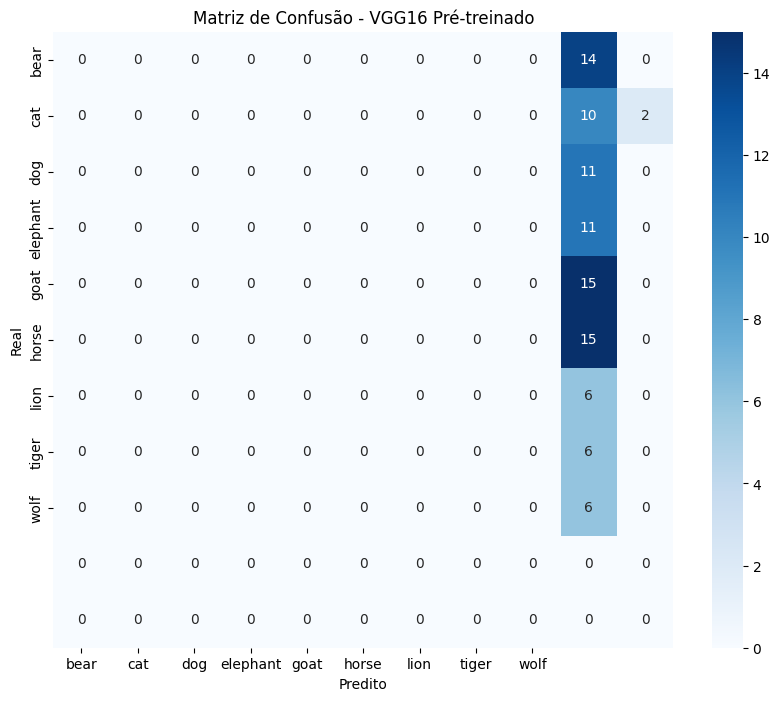

📊 Relatório - VGG16 Pré-treinado


ValueError: Number of classes, 11, does not match size of target_names, 9. Try specifying the labels parameter

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Caminhos
DATASET_PATH = "/content/drive/MyDrive/ISEP/dataset"
VAL_PATH = os.path.join(DATASET_PATH, "validation")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
class_names = ['bear', 'cat', 'dog', 'elephant', 'goat', 'horse', 'lion', 'tiger', 'wolf']

# Gerador de validação
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Função de avaliação de modelo
def avaliar_modelo(nome_modelo, caminho_modelo):
    print(f"\n🧠 Avaliando modelo: {nome_modelo}")
    model = load_model(caminho_modelo)

    val_generator.reset()
    preds = model.predict(val_generator, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_generator.classes

    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Matriz de Confusão - {nome_modelo}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # Relatório
    print(f"📊 Relatório - {nome_modelo}")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Acurácia top-1
    acc = np.mean(y_pred == y_true)
    print(f"🎯 Acurácia Top-1: {acc*100:.2f}%")
    return acc * 100


# Avaliar os três modelos
acuracias = {}
acuracias["Pré-treinado"] = avaliar_modelo("VGG16 Pré-treinado", "/content/drive/MyDrive/ISEP/modelo_vgg16_pretreinado.keras")
acuracias["Transfer Learning"] = avaliar_modelo("VGG16 Transfer Learning", "/content/drive/MyDrive/ISEP/modelo_vgg16_transfer.keras")
acuracias["Do Zero"] = avaliar_modelo("VGG16 do Zero", "/content/drive/MyDrive/ISEP/modelo_vgg16_zero.keras")

# Gráfico comparativo
plt.figure(figsize=(8, 5))
plt.bar(acuracias.keys(), acuracias.values(), color=["#1f77b4", "#2ca02c", "#d62728"])
plt.title("Comparação de Acurácia Final - Modelos VGG16")
plt.ylabel("Acurácia (%)")
plt.ylim(0, 100)
plt.grid(axis="y")
for i, v in enumerate(acuracias.values()):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()
